# INFO 3350/6350

## Lecture 04: Regression

## To do

* Waitlist should now be cleared ...
* Readings for today/Friday
  * NetIDs H-P response to Davis due tonight by 4pm
* PS1 due *next* week, not this week
  * It will take 5-10 hours. Do not begin working on it the day it's due.
* Questions?

## TF-IDF weighting for word counts

* Why do we sometimes remove stopwords from our features?
    * High-frequency words shared by many documents don't tell us (in many, but not all, cases) much about the similarities or differences between documents
* But stopword lists are binary: a word is either a stopword (hence, removed) or it isn't
* Can we define a continuous adjustment for "stoppiness" that we apply to *every* word, depending on how widely used it is?
* One approach is "term frequency-inverse document frequency" (TFIDF) weighting. 
    * You can think of this as multiplying the count of each term in a document by the inverse of the fraction of all documents in which that word occurs (hence "term frequency [multiplied by] inverse document frequency"). It's a bit more complicated than that (see below), but that's the idea. This upweights words that occur in relatively few documents.
    * The count of a word that occurs in every document would be multiplied by one, hence get no boost in each document. A word that occurs in just one document in a corpus of 100 documents would be multiplied by 100 in the one document that contains it.
* There are several tweaks to TFIDF to smooth it out and to modulate the boost it provides. `scikit-learn`'s `TfidfVectorizer` applies the reweighting:

$$\text{idf}(t) = \ln\frac{1+n}{1 + \text{df}(t)} + 1$$

Where:

* $t$ is the term in question
* $\text{idf}(t)$ is the inverse document weight to be applied to the count of term $t$
* $n$ is the number of documents in the corpus
* $\text{df}(t)$ is the number of documents in the corpus that contain term $t$

A toy example: Consider two documents:

* Document 1: `"cat dog"`
* Document 2: `"dog dog"`

`cat` occurs in just one document; `dog` occurs in both documents. So we want (and expect) to upweight the count of `cat` in document 1.

Calculate the `idf` weight for `cat` in document 1:

* $n = 2$
* $\text{df}(\text{'cat'}) = 1$

$$\text{idf}(\text{'cat'}) = \ln\frac{1 + 2}{1 + 1} + 1 = \ln\frac{3}{2} + 1 = 1.405$$

And for `dog` in document 1:

* $n = 2$
* $\text{df}(\text{'dog'}) = 2$

$$\text{idf}(\text{'dog'}) = \ln\frac{1 + 2}{1 + 2} + 1 = \ln\frac{3}{3} + 1 = 1.0$$

So, `cat` will be upweighted relative to `dog`, because it is the less widely used word across documents in the corpus.

Our non-normalized but IDF-weighted feature matrix will look like this:

```
cat  dog
1.4  1.0
0    2.0
```

In code:

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    "cat dog",
    "dog dog",
]

# without IDF weighting (note l2 norm)
vectorizer_no_idf = TfidfVectorizer(
    use_idf=False
)
features_no_idf = vectorizer_no_idf.fit_transform(corpus)
print("### Feature matrix *without* IDF weighting ###")
print("Feature names:", vectorizer_no_idf.get_feature_names_out())
print(features_no_idf.toarray())

# with IDF weighting
vectorizer_with_idf = TfidfVectorizer(
    use_idf=True,
)
features_with_idf = vectorizer_with_idf.fit_transform(corpus)
print("\n### Feature matrix *with* IDF weighting ###")
print("Feature names:", vectorizer_with_idf.get_feature_names_out())
print(features_with_idf.toarray())

### Feature matrix *without* IDF weighting ###
Feature names: ['cat' 'dog']
[[0.70710678 0.70710678]
 [0.         1.        ]]

### Feature matrix *with* IDF weighting ###
Feature names: ['cat' 'dog']
[[0.81480247 0.57973867]
 [0.         1.        ]]


Notice that, in document 1, `cat` has been up-weighted while `dog` has been downweighted. There's no change in document 2 because that document has only a single word type and `TfidfVectorizer`'s `l2` norm enforces total feature weights whose squares sum to 1.

In [2]:
# Check our hand calculation against code version
import numpy as np
vec = np.array([1.405, 1.0])     # hand calculation
l2_vec = vec/np.linalg.norm(vec) # calculate l2 normalized version
print("l2-normed, hand calculated, IDF weighted features for document 1")
print(l2_vec)

l2-normed, hand calculated, IDF weighted features for document 1
[0.81471182 0.57986606]


In [3]:
# do our two versions match?
assert np.allclose(l2_vec, features_with_idf[0,].toarray(), atol=0.01)

## Regression

We are often interested in the relationships between measured properties of texts, or between a textual property and some continuous variable (year of publication, number of sales, and so on).

Maybe the most basic way to measure the relationship between two variables is to use **linear regression**. The idea is to calculate a straight line through your data such that the average distance between the observed data points and the line is as small as possible. 

(Sketch what this looks like)

You can then calculate the **coefficient of determination**, written $r^2$ ("r squared"), which measures the fraction of the variation in the dependent (y) variable that is predictable from the independent (x) variable.

$r^2$ = 1 - (sum of squared residuals)/(sum of squared values)

A *residual* is the amount by which the actual value differs from the predicted value. The "squared values" in this equation is the amount by which each actual value differs from the mean of all the actual values. 

In effect, $r^2$ measures the amount by which the predicted values outperform a simple guess of the mean of the dataset when asked for a prediction of the dependent variable across all observed independent variables. This also explains how it's possible for $r^2$ to be negative: if our model is bad enough, it can perform worse than guessing the mean.

An $r^2$ value of 1 indicates perfect correlation between the variables; zero means no correlation. 

* There's a *lot* more to this. We'll spend some time on it later in the semester.
* For now, focus on the fact that regression is a way to calculate a line of best fit through a data set.
* Notice that we could also try to find something like a "line of *worst* fit," which we could think of as the dividing line between two regions of feature space. This would be something like the line on which we are least likely to encounter any actual data points. 
  * Think about what use-value such a dividing line might have ...

## Example: character space

Let's say we have two competing theories about how narrative space is allocated to characters in novels. These can be summarized as:

1. Theory 1: Novels generally contain a fixed amount of character space. If a text allocates more space to characters of one type, it must necessarily allocate less space to characters of other types. This is a constraint imposed by what it means to tell a story.
2. Theory 2: There is a (wide?) range of amounts of character space that a novel might use. Some novels spend a lot of time talking about their characters; others, very little. If we see a lot of one type of character, we're likely to see a lot of other character types, too.

How could we test these competing models of narrative?

First, we need to work out the measurable implications of each model:

* We'll use the number of pronouns as a simple proxy for character space.
* We'll use pronoun genders as our target for character types.
    * Specifically, `she/her/hers` vs. `he/him/his` vs. `they/them/their/theirs`
* In both cases, we'll normalize by book length (by dividing the count of each pronoun class by the total number of tokens in the book).
* If theory 1 is correct, we'll expect to see fewer `she` pronouns in books that use more `he` pronouns. Ditto `he/they` and `she/they`.
* If theory 2 is correct, we'll expect to see the opposite: more pronouns of all types when any one of the types is higher.

We'll use our corpus of 42 novels, mostly British and American, all in English, published during the long nineteenth century.

In [4]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

# pronoun sets
f_words = ['she', 'her', 'hers']
m_words = ['he', 'him', 'his']
t_words = ['they', 'them', 'their', 'theirs']

vectorizer = TfidfVectorizer(
    use_idf=False,
    norm=None,
    lowercase=True,
    strip_accents='unicode',
    input='filename',
    encoding='utf-8',
    #vocabulary= f_words + m_words + t_words
)

data_dir = os.path.join('..', 'data', 'texts')
files = os.listdir(data_dir)

# vectorize and length-normalize
data = vectorizer.fit_transform([os.path.join(data_dir, filename) for filename in files])
data = pd.DataFrame.from_records(data.toarray(), columns=vectorizer.get_feature_names_out(), index=files)
data = data.div(data.sum(axis='columns'), axis='rows')

In [5]:
data.shape

(42, 54844)

In [6]:
def process_type(data, words, norm=True):
    '''A function to gather and sum words of a single type/class. Z-scores output by default.'''
    output = data.loc[:,words].sum(axis='columns')
    if norm:
        output = (output - output.mean())/output.std()
    return output

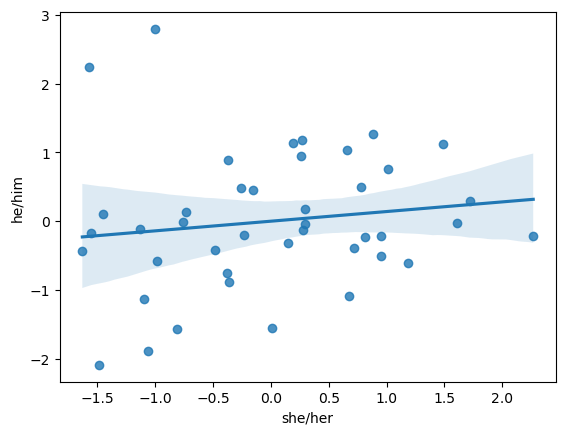

In [7]:
# plot m vs f pronoun classes
sns.regplot(x=process_type(data, f_words), y=process_type(data, m_words))
plt.xlabel("she/her")
plt.ylabel("he/him")
plt.show()

In [8]:
# fit data and score model
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(
    X=pd.DataFrame(process_type(data, f_words)), 
    y=process_type(data, m_words))

print(f"Coefficient: {regressor.coef_.item():>7.4f}")
print(f"Intercept:   {regressor.intercept_.item():>7.4f}")
print(f"R^2:         {regressor.score(X=pd.DataFrame(process_type(data, f_words)), y=process_type(data, m_words)):>7.4f}")

Coefficient:  0.1405
Intercept:    0.0000
R^2:          0.0197


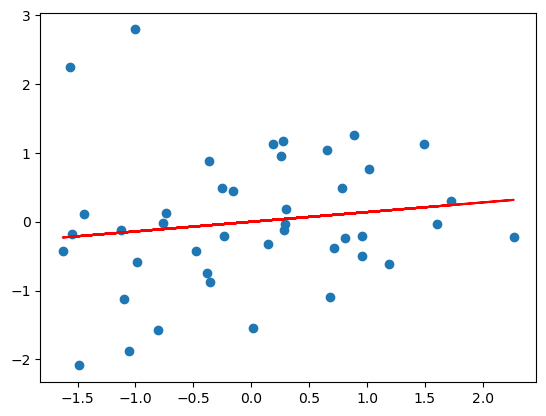

In [9]:
# plot predictions from model
import matplotlib.pyplot as plt
plt.scatter(x=process_type(data, f_words), y=process_type(data, m_words))
plt.plot(process_type(data, f_words), regressor.predict(X=pd.DataFrame(process_type(data, f_words))), c='red')
plt.show()

In [10]:
# run all three possible pairings
pairs = {
    'He-she': (m_words, f_words),
    'He-they': (m_words, t_words),
    'She-they': (f_words, t_words)
}

def compare_types(data, dep_words, indep_words, name=''):
    regressor = LinearRegression()
    regressor.fit(X=pd.DataFrame(process_type(data, indep_words)), y=process_type(data, dep_words))

    print(name)
    print(f"  Coefficient: {regressor.coef_.item():>7.4f}")
    print(f"  Intercept:   {regressor.intercept_.item():>7.4f}")
    print(f"  R^2:         {regressor.score(X=pd.DataFrame(process_type(data, indep_words)), y=process_type(data, dep_words)):>7.4f}")
    print()
    return(regressor)

for key in pairs:
    compare_types(data, *pairs[key], name=key)

He-she
  Coefficient:  0.1405
  Intercept:    0.0000
  R^2:          0.0197

He-they
  Coefficient: -0.0277
  Intercept:    0.0000
  R^2:          0.0008

She-they
  Coefficient: -0.1372
  Intercept:    0.0000
  R^2:          0.0188



Hmm ... these effects are really weak. Is something broken? Let's try terms that we expect to be strongly correlated ...

In [11]:
new_pairs = {
    'Whale-fish': (['whale'], ['fish']),
    'God-heaven': (['god'], ['heaven']),
    'Mother-son': (['mother'], ['son']),
    '1st p-3rd p': (['me', 'my', 'mine'], ['he', 'his', 'she', 'her']),
}
for key in new_pairs:
    compare_types(data, *new_pairs[key], name=key)

Whale-fish
  Coefficient:  0.7695
  Intercept:    0.0000
  R^2:          0.5921

God-heaven
  Coefficient:  0.5223
  Intercept:   -0.0000
  R^2:          0.2728

Mother-son
  Coefficient:  0.3328
  Intercept:   -0.0000
  R^2:          0.1108

1st p-3rd p
  Coefficient: -0.4974
  Intercept:   -0.0000
  R^2:          0.2474



OK, so there *are* correlations in the data, just not unambiguous evidence to help us decide between out competing theories.

Finally, let's get the most strongly correlated terms in the corpus:

In [12]:
# get 1000 most common words in the corpus
top_terms = data.sum(axis='rows').sort_values().tail(1000).index

# calculate correlations and remove self-correlations
correlations = data.loc[:,top_terms].corr()
np.fill_diagonal(correlations.values, np.nan)

# examine most correlated and anti-correlated terms
size = len(correlations)
print("Most positively correlated:")
for j, i in enumerate(np.argsort(correlations, axis=None)[-1040:-1000][::-1]):
    if j%2==0:
        rowidx = correlations.index[i//size]
        colidx = correlations.columns[i%size]
        value = correlations.loc[rowidx, colidx]
        print(f"{rowidx:<10} {colidx:<10} {value:7.4f}")
        
print("\nMost negatively correlated:")
for j, i in enumerate(np.argsort(correlations, axis=None)[:40]):
    if j%2==0:
        rowidx = correlations.index[i//size]
        colidx = correlations.columns[i%size]
        value = correlations.loc[rowidx, colidx]
        print(f"{rowidx:<10} {colidx:<10} {value:7.4f}")

Most positively correlated:
jimmie     deh         1.0000
corey      lapham      1.0000
hurstwood  carrie      1.0000
laura      jadwin      0.9999
bambi      elder       0.9962
deh        pete        0.9959
pete       jimmie      0.9959
deh        hell        0.9958
hell       jimmie      0.9958
negro      ter         0.9947
pete       hell        0.9943
iola       war         0.9937
dogs       buck        0.9930
hester     minister    0.9650
dogs       dog         0.9602
didn       wouldn      0.9508
heathcliff catherine   0.9500
barney     rose        0.9491
buck       dog         0.9485
couldn     didn        0.9374

Most negatively correlated:
of         go         -0.8336
will       back       -0.7747
back       object     -0.7371
the        wish       -0.7335
have       down       -0.7328
do         the        -0.7327
received   like       -0.7231
over       have       -0.7175
should     over       -0.7153
better     the        -0.7142
present    like       -0.7116
if         th

In [13]:
# check out the volume-wise values for a single term
data.loc[:,'jimmie'].sort_values(ascending=False)

A-Crane-Maggie-1893-M.txt                   0.005743
B-Wells-Time_Machine-1895-M.txt             0.000000
B-Stevenson-Treasure_Island-1883-M.txt      0.000000
A-James-Golden_Bowl-1904-M.txt              0.000000
A-Alcott-Little_Women-1868-F.txt            0.000000
B-Conrad-Heart_Darkness-1902-M.txt          0.000000
O-Salten-Bambi-1923.txt                     0.000000
B-Eliot-Middlemarch-1869-F.txt              0.000000
F-Flaubert-Madame_Bovary-1857-M.txt         0.000000
A-London-Call_Wild-1903-M.txt               0.000000
A-Twain-Huck_Finn-1885-M.txt                0.000000
B-Disraeli-Sybil-1845-M.txt                 0.000000
A-Chopin-Awakening-1899-F.txt               0.000000
B-Mitford-Our_Village-1826-F.txt            0.000000
B-Radcliffe-Mysteries_Udolpho-1794-F.txt    0.000000
A-Davis-Life_Iron_Mills-1861-F.txt          0.000000
A-Wharton-Age_Innocence-1920-F.txt          0.000000
B-Gaskell-North_South-1855-F.txt            0.000000
B-Trollope-Live_Now-1875-M.txt              0.

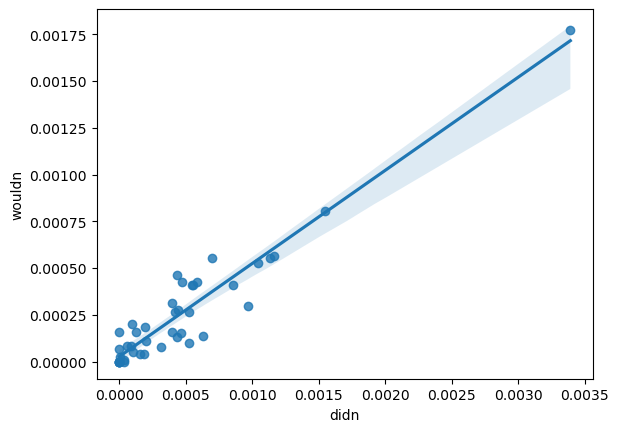

In [14]:
# strong positive correlation
sns.regplot(data, x='didn', y='wouldn');

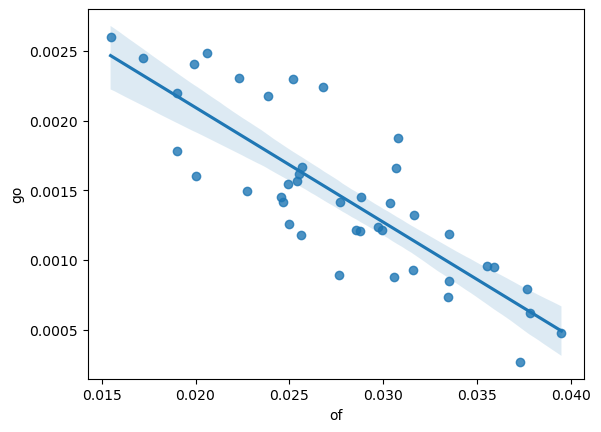

In [15]:
# strong negative correlation
sns.regplot(data, x='of', y='go');

In [16]:
# how does the TfidfVectorizer handle contractions?
vec = TfidfVectorizer(input='content')
vec.fit_transform(["wouldn't", "can't"])
vec.get_feature_names_out()

array(['can', 'wouldn'], dtype=object)